# Intel Stock Analysis

Brandon Chan 05/01/2023

## Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split 
from datetime import datetime
import warnings 
warnings.filterwarnings('ignore')
import requests 
from bs4 import BeautifulSoup

In [69]:
data = pd.read_csv("INTC.csv")
data['Date'] = pd.to_datetime(data['Date'])
data['Date_Ordinal'] = data['Date'].apply(lambda x: x.toordinal())
data.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,Date_Ordinal
1255,2024-04-25,34.560001,35.299999,34.500000,35.110001,35.110001,66549400,739001
1256,2024-04-26,31.780001,32.240002,30.639999,31.879999,31.879999,119742500,739002
1257,2024-04-29,31.860001,31.910000,31.070000,31.360001,31.360001,58533300,739005
1258,2024-04-30,31.040001,31.180000,30.420000,30.469999,30.469999,72166600,739006
1259,2024-05-01,30.160000,30.530001,30.020000,30.137501,30.137501,11454808,739007


## 5 Year Trend

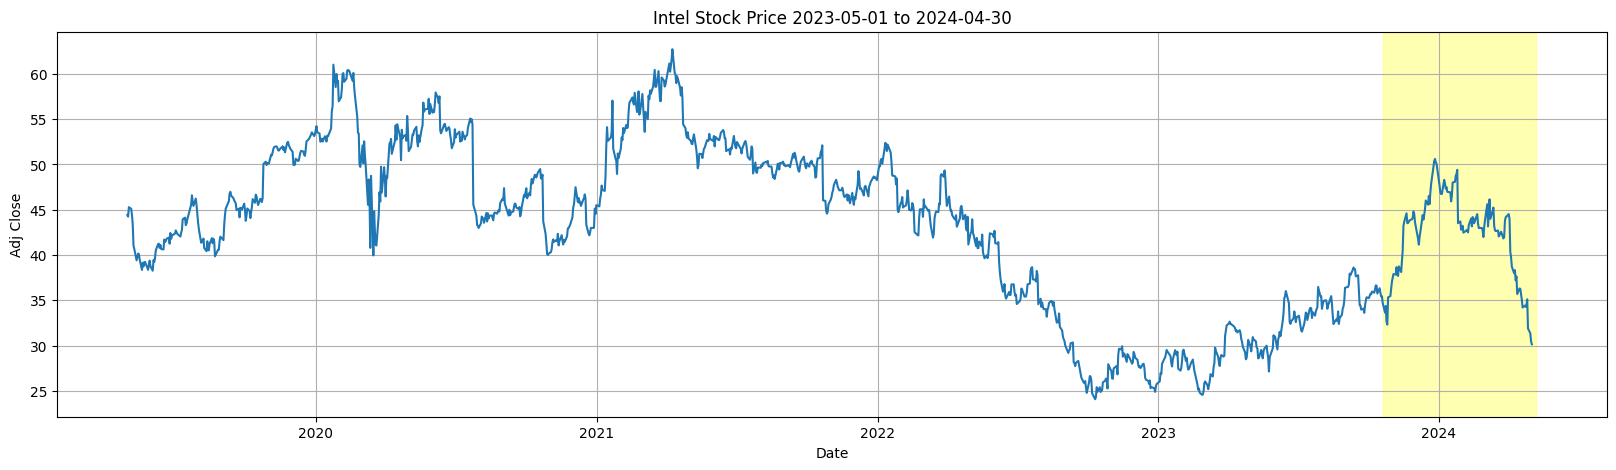

In [81]:
# Add a column to indicate the trend (1 for increasing, -1 for decreasing)
data['Trend'] = (data['Adj Close'] - data['Adj Close'].shift(1)).fillna(0)
data.loc[data['Trend'] > 0, 'Trend'] = 1
data.loc[data['Trend'] < 0, 'Trend'] = -1

# Time series plot stock price 
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data, x="Date", y="Adj Close", ax=ax)
ax.set_title("Intel Stock Price 2023-05-01 to 2024-04-30")
ax.grid()

# Highlight near current date 
plt.axvspan(19650, 19850, color='yellow', alpha=0.3)

plt.show()

Stock peaked in early January, currently at it's lowest point in 2024. No significant reason found for the falling price (over blown AI enthusiasm?). People think that Intel will not do well in the upcoming AI boom. Too many resources/not enough competitors (my opinion).     

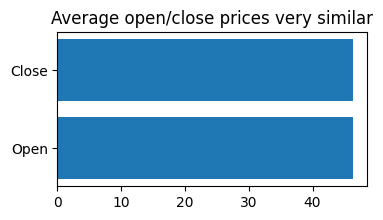

Average difference open-close -0.005299545238095504


In [58]:
# Plotting Open/Close prices 
x=["Open", "Close"]
y=[np.mean(data.Open), np.mean(data.Close)] 

fig, ax = plt.subplots(figsize = (4, 2))
plt.barh(width=y, y=x)
plt.title("Average open/close prices very similar") 
plt.show()

avg_diff_oc = np.mean(data.Open - data.Close)

print(f"Average difference open-close {avg_diff_oc}")
# So not very significant

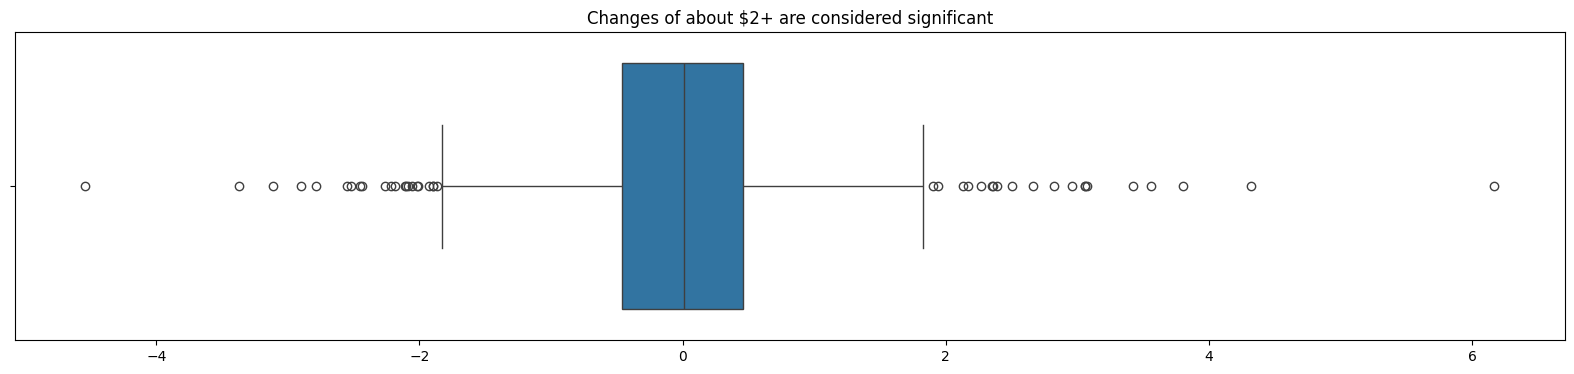

In [51]:
# Looking for outliers in price differences 
day_change = data.Close - data.Open
fig, ax=plt.subplots(figsize=(20, 4))
sns.boxplot(day_change, orient="h")
plt.title("Changes of about $2+ are considered significant")
plt.show()
# Occasionaly an outlier, more significant for decreases in the closing price.   

Price tends to fall by an insignificant amount (quite a few outliers - may be unreliable). May be worth it to wait until near close, but not very likely. 

## Close vs Adjclose 
Evaluating siginificance of adjusted close price 

Average difference close-adjusted close price $3.142908892857143


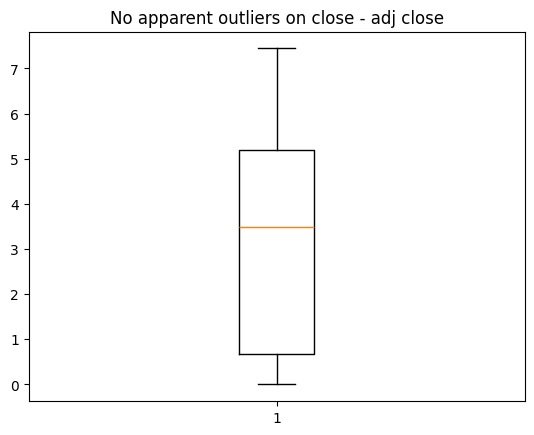

In [40]:
print(f"Average difference close-adjusted close price ${np.mean(data['Close'] - data['Adj Close'])}")

plt.boxplot(data['Close'] - data['Adj Close'])
plt.title("No apparent outliers on close - adj close")
plt.show()

So the adjusted close price seems to be about $3.14 lower on average. May be significant, should use adjusted close price. 

## Volume Time Series    

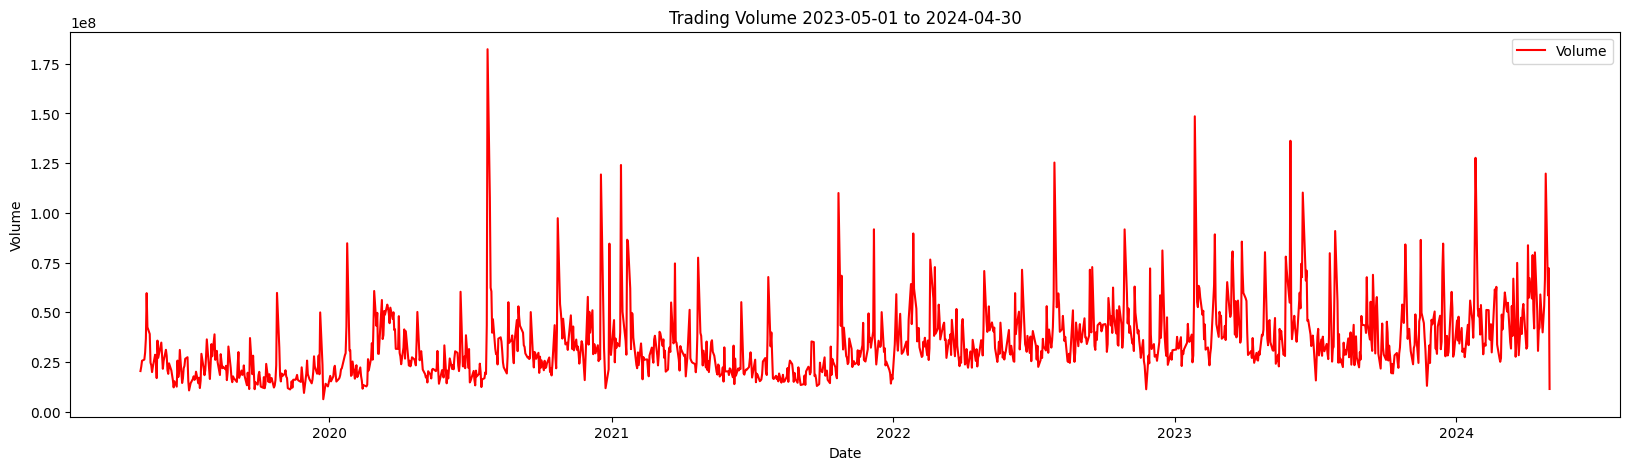

In [41]:

fig, ax=plt.subplots(figsize=(20, 5))
sns.lineplot(data, x="Date", y="Volume", ax=ax, color="red", label="Volume") 
ax.set_title("Trading Volume 2023-05-01 to 2024-04-30")  
plt.show()

## Find Correlation Between Extreme Volume and Price

In [42]:
corr_vol_price = np.corrcoef(data.Volume, data['Adj Close'])[0][1]
extreme_vol = data[data.Volume>100000000]
cvp_extreme = np.corrcoef(extreme_vol.Volume, extreme_vol['Adj Close'])[0][1]
print(f"Correlation between Volume vs Price {corr_vol_price}")
print(f"Correlation between Extreme Volume vs Price {cvp_extreme}")

Correlation between Volume vs Price -0.3322926471852537
Correlation between Extreme Volume vs Price -0.09345660913949973


## Simple Linear Regression Prediction: Use Date to Predict Price 

So on days with higher trade volume, the adjusted close price generally decreases. The correlation is less clear for days with extremely high trading volume. My guess is that days with extreme volumes of trading either drive up or drive down the price fairly significantly, effectively cancelling each other out. 

Linear regression expected price: $34.14419928507232


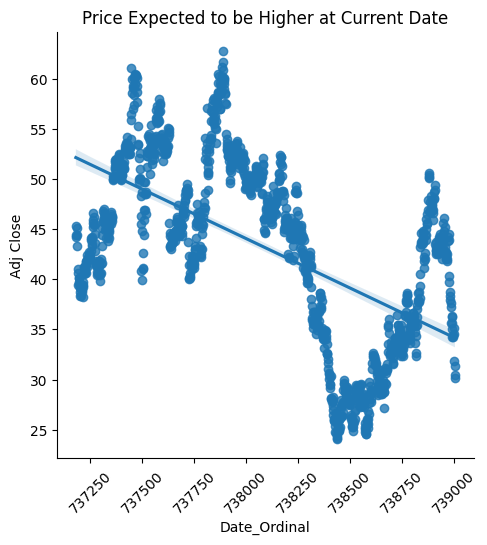

In [48]:
model = LinearRegression()
model.fit(data[['Date_Ordinal']], data['Adj Close'])
expected_price = model.predict([[datetime.now().date().toordinal()]])[0]

print(f"Linear regression expected price: ${expected_price}")


sns.lmplot(data, x='Date_Ordinal', y='Adj Close')
plt.title("Price Expected to be Higher at Current Date")
plt.xticks(rotation = 45)
plt.show()

The linear regression model predicts the stock to be up about $4 from what it is currently. Further confirms my thoughts, although using the date as the predictor seems a little iffy.

## Simple Linear Regression Prediction: Use Volume to Predict Price 

Text(0.5, 1.0, 'Non-linear, ugly pattern but higher volume tends to coincide with lower price')

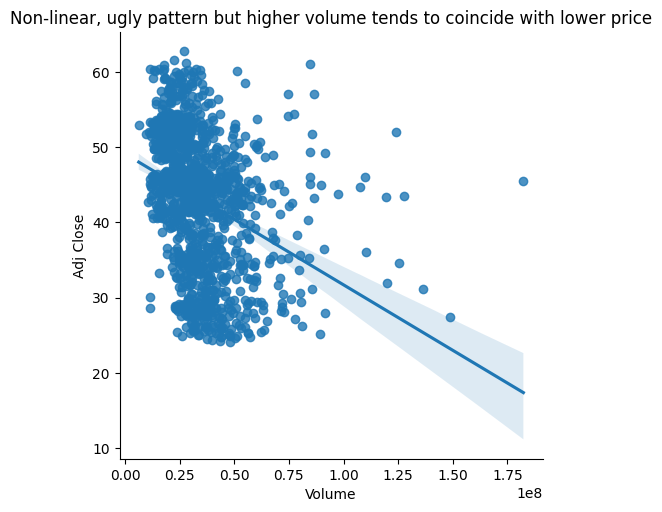

In [83]:
model = LinearRegression()
model.fit(data[['Volume']], data['Adj Close'])
data['Volume Price Prediction'] = model.predict(data[['Volume']])
# print(data.tail(5))
sns.lmplot(data, x='Volume', y='Adj Close')
plt.title("Non-linear, ugly pattern but higher volume tends to coincide with lower price")

The price is generally expected to be higher as of late based on trading volume. 

## Predicting Price with Volume and Date (Multiple Linear Regression) 

In [47]:
model = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(data[['Date_Ordinal', 'Volume']], data['Adj Close'], test_size = 0.10)

model.fit(X_train, y_train) 

date = 739006
volume = 72166600
price_prediction = model.predict([[date, volume]])[0] 

print(f"Adjusted close price prediction using date and volume: ${price_prediction}")

Adjusted close price prediction using date and volume: $32.625446857182396


# Temporary Conclusion 

All signs seem to support my original hypothesis, that Intel stock is a good investment as of May 1st, 2024. The current generation Intel Meteor Lake CPU's are also on par with AMD's for consumer products. Based on the current price predictions of the models and the quality of Intel's products, I think that the stock should be trading at a much price. 